# Generate Perfusion Maps

This tutorials present a step-by-step set of instructions on how to generate the required perfusion maps (Time-To-Peak, Mean Transit Time, Cerebral Blood Flow and Cerebral Blood Volume), on a specified DCE-MRI and its corresponding tumor mask.

<a target="_blank" href="https://colab.research.google.com/github/MAIA-KTH/Hive_ML/blob/master/tutorials/0-Generate_Perfusion_Maps.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

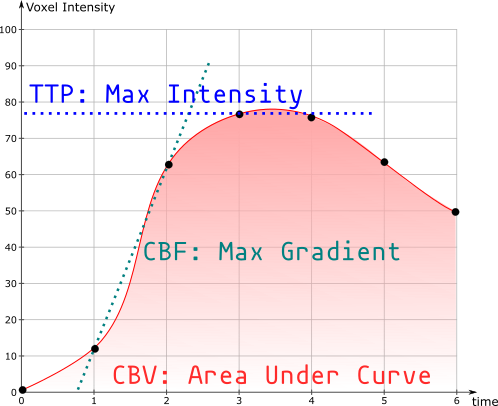

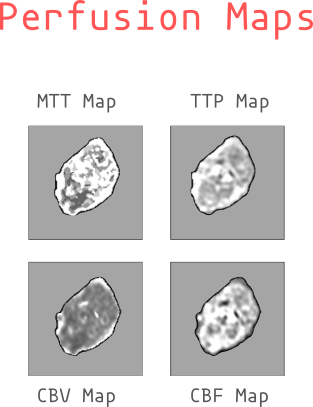

First, we define the set of functions to generate the perfusion maps:

In [1]:
import numpy as np
import SimpleITK as sitk
import copy
import importlib

## TTP Map

$TTP=argmax_t(DCE MRI_(x,y,z,t))$

In [2]:
def extract_ttp(array,acc="argmax"):
    temporal_axis = np.argmin(array.shape)
    
    
    m = importlib.import_module("numpy")
    acc_fn = getattr(m, acc)
    
    ttp_array = acc_fn(array, axis=temporal_axis).astype(np.uint8)
    ttp_array = ttp_array + 1
    ttp_array = np.where(ttp_array > array.shape[temporal_axis],  array.shape[temporal_axis], ttp_array)

    return ttp_array

def generate_ttp_image(image_filename, mask_filename, output_filename):

    image = sitk.ReadImage(image_filename)
    mask = sitk.ReadImage(mask_filename)

    mask_array = sitk.GetArrayFromImage(mask)

    ttp_array= extract_ttp(sitk.GetArrayFromImage(image))
    ttp_array = np.where(mask_array == 0, mask_array, ttp_array)

    ttp_image = sitk.GetImageFromArray(ttp_array)
    ttp_image.CopyInformation(mask)
    sitk.WriteImage(ttp_image, output_filename)

## CBV Map

$CBV=\sum_{t=0}^n DCEMRI_(x,y,z,t)$

In [3]:
def extract_cbv(array):
    temporal_axis = np.argmin(array.shape)
    cbv_map = np.sum(array, axis=temporal_axis)

    return cbv_map

def generate_cbv_image(image_filename, mask_filename, output_filename):
    image = sitk.ReadImage(image_filename)
    mask = sitk.ReadImage(mask_filename)
    image_array = sitk.GetArrayFromImage(image)
    mask_array = sitk.GetArrayFromImage(mask)

    cbv_map = extract_cbv(image_array)
    cbv_map = cbv_map*mask_array
    cbv_image = sitk.GetImageFromArray(cbv_map)
    cbv_image.CopyInformation(mask)
    sitk.WriteImage(cbv_image, output_filename)

## CBF Map

$CBF = max(\frac{\nabla DCEMRI_(x,y,z,t)}{\nabla t})$

In [4]:
def extract_cbf(array,acc="max"):
    temporal_axis = np.argmin(array.shape)

    if temporal_axis !=0:
        array = np.transpose(array,(temporal_axis,0,1,2))
    gradient_image = copy.deepcopy(array)

    t_size = gradient_image.shape[0]

    for t in range(1,t_size):
        gradient_image[t,:] = array[t,:] - array[t-1,:]
    gradient_image[0, :] = 0

    m = importlib.import_module("numpy")
    acc_fn = getattr(m, acc)

    cbf_map = acc_fn(gradient_image, axis=0)

    return cbf_map

def generate_cbf_image(image_filename, mask_filename, output_filename):
    image = sitk.ReadImage(image_filename)
    mask = sitk.ReadImage(mask_filename)
    image_array = sitk.GetArrayFromImage(image)
    mask_array = sitk.GetArrayFromImage(mask)

    cbf_map =extract_cbf(image_array)
    cbf_map = cbf_map*mask_array
    cbf_image = sitk.GetImageFromArray(cbf_map)
    cbf_image.CopyInformation(mask)
    sitk.WriteImage(cbf_image, output_filename)

## MTT Map

$MTT = \frac{CBV}{CBF}$

In [5]:
def extract_mtt(array, acc="max"):
    temporal_axis = np.argmin(array.shape)

    if temporal_axis != 0:
        array = np.transpose(array, (temporal_axis, 0, 1, 2))

    gradient_image = copy.deepcopy(array)
    t_size = gradient_image.shape[0]
    for t in range(1, t_size):
        gradient_image[t, :] = array[t, :] - array[t - 1, :]
    gradient_image[0, :] = 0
    
    m = importlib.import_module("numpy")
    acc_fn = getattr(m, acc)
    cbf_map = acc_fn(gradient_image, axis=0).astype(float)
    cbv_map = np.sum(array, axis=0).astype(float)

    mtt_map = np.divide(cbv_map, cbf_map,out=np.zeros_like(cbv_map), where=cbf_map != 0)

    return mtt_map

def generate_mtt_image(image_filename, mask_filename, output_filename):
    image = sitk.ReadImage(image_filename)
    mask = sitk.ReadImage(mask_filename)
    image_array = sitk.GetArrayFromImage(image)
    mask_array = sitk.GetArrayFromImage(mask)

    mtt_map = extract_mtt(image_array)
    mtt_map = mtt_map*mask_array
    mtt_image = sitk.GetImageFromArray(mtt_map)
    mtt_image.CopyInformation(mask)
    sitk.WriteImage(mtt_image, output_filename)

## Select DCE-MRI Sample

In [6]:
data_folder = "Data/DCE_MRI_dataset"
image_suffix = "_cropped.nii.gz" 
mask_suffix = "_mask.nii.gz"
patient_class = "pCR"
patient_id = "Patient09"

In [7]:
from pathlib import Path

image_filename = str(Path(data_folder).joinpath(patient_class, patient_id,patient_id+image_suffix))
mask_filename = str(Path(data_folder).joinpath(patient_class,patient_id, patient_id+mask_suffix))

### Create Perfusion Maps

In [8]:
import tempfile


temp_dir = tempfile.TemporaryDirectory()
generate_mtt_image(image_filename,mask_filename,str(Path(temp_dir.name).joinpath(patient_id+"_mtt.nii.gz")))
generate_ttp_image(image_filename,mask_filename,str(Path(temp_dir.name).joinpath(patient_id+"_ttp.nii.gz")))
generate_cbv_image(image_filename,mask_filename,str(Path(temp_dir.name).joinpath(patient_id+"_cbv.nii.gz")))
generate_cbf_image(image_filename,mask_filename,str(Path(temp_dir.name).joinpath(patient_id+"_cbf.nii.gz")))



## Visualize Map

In [ ]:
!pip install itk
!pip install "itkwidgets[all]>=1.0a23"


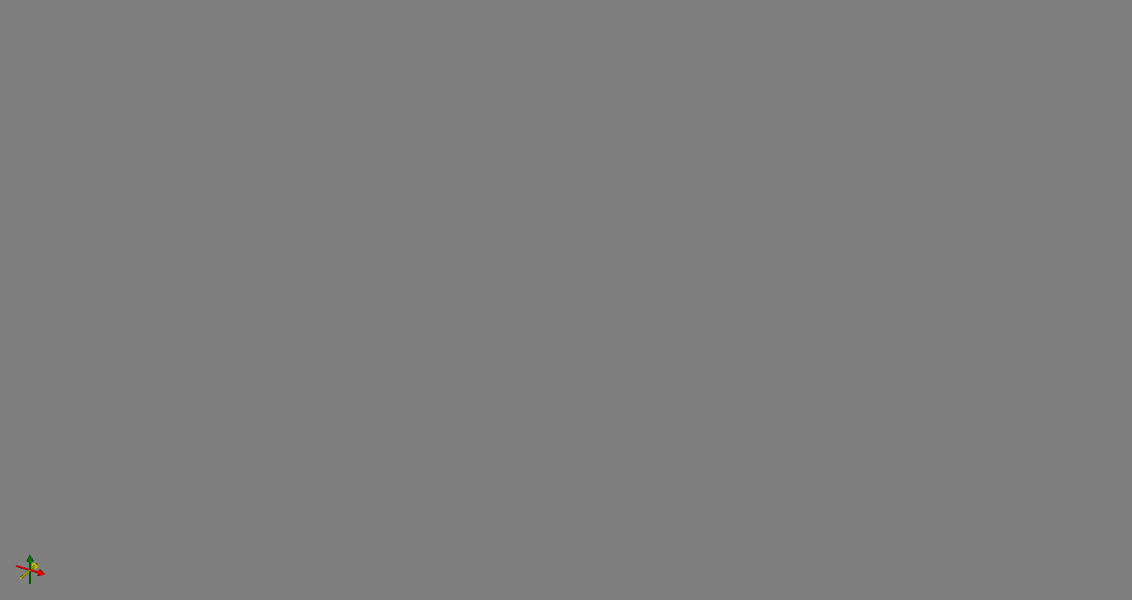
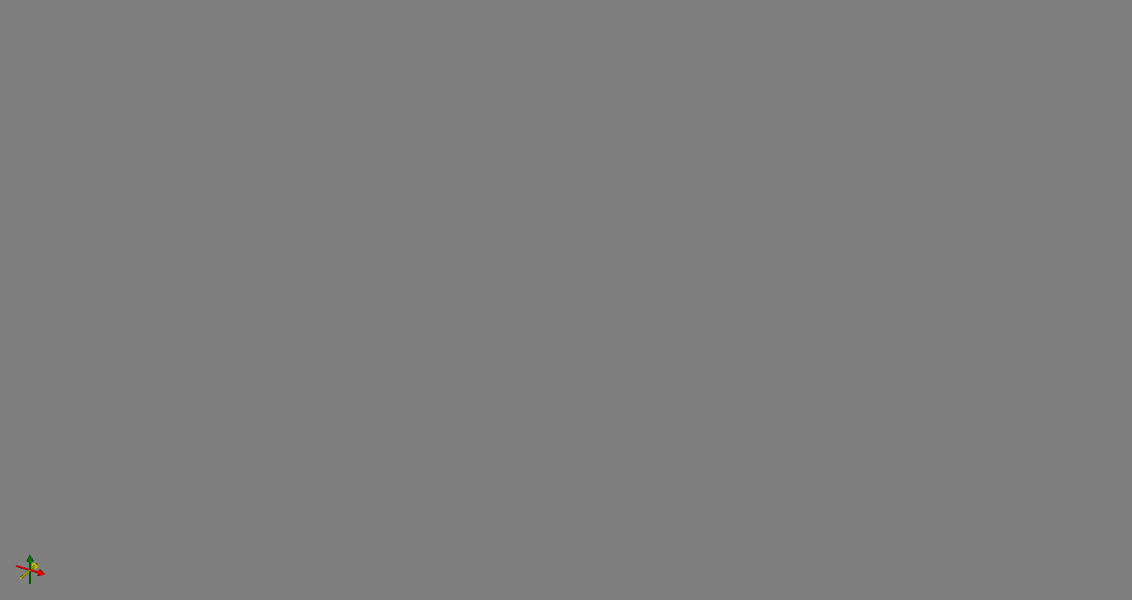

<IPython.core.display.Javascript object>

In [9]:
import itk
from itkwidgets import view
image = itk.imread(str(Path(temp_dir.name).joinpath(patient_id+"_cbf.nii.gz")))

view(image,gradient_opacity=1.0, gradient_opacity_scale=1.0)